# Back-testing with Delta-Gamma Hedging Strategy

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime
from scipy.stats import norm

from api.definer.data import graph
from api.definer.instruments import *
from api.definer.linear import LinearRegressionModel
from api.definer.core import *

import matplotlib as mpl
mpl.style.use('default')

import warnings
warnings.simplefilter("ignore")

In [2]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.random.manual_seed(random_state)

print('Set random seed: {}'.format(random_state))

Set random seed: 0


In [3]:
LIVE = False
SAVE = True
AROUND = True

## Collect Historical Data in USDC-ETH 0.05% Uniswap V3 pool

In [4]:
# USDC-ETH 0.05% Uniswap V3 pool on Ethereum chain
if LIVE:
    address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
    after = '2022-01-01'
    dpd = graph(address, int(datetime.timestamp(datetime.strptime(after, "%Y-%m-%d"))))
    # dpd.to_csv('./data/uniswap_v3_usdc_eth.csv')
else:
    dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])

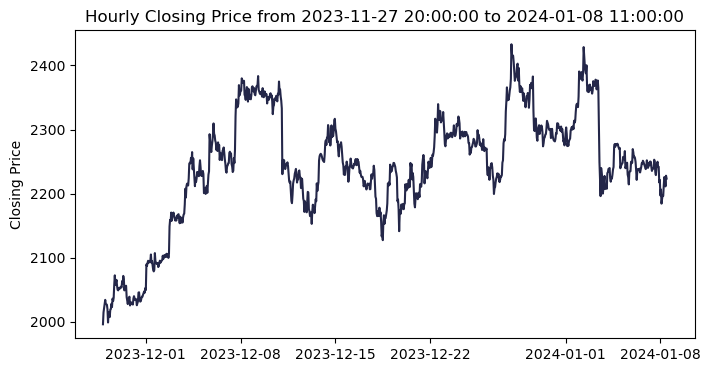

In [5]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=pd.to_datetime(dpd.periodStartUnix, unit='s'), y=dpd.close, color='#242749')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Hourly Closing Price from {} to {}'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d %H:%M:%S'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d %H:%M:%S')))
plt.ylabel('Closing Price')
plt.xlabel(None)
# if SAVE: plt.savefig('./img/back-testing_historical_price.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
n = 1
mini = 1882.32
maxi = 2519.99
target = dpd['close'].iloc[-1] * n
base = 0

In [7]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0

dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)

dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']

In [8]:
SMIN = np.sqrt(mini * 10 ** decimal)
SMAX = np.sqrt(maxi * 10 ** decimal)

initial_price = dpd['close'].iloc[-1]
print("Starting (initial) price:", dpd['close'].iloc[-1])

Starting (initial) price: 1995.8472015960615


In [9]:
if base == 0:  # Token 0 USDC as the base token

    sqrt0 = np.sqrt(dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = dpd['close']

else:

    sqrt0 = np.sqrt(1 / dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = 1 / dpd['close']


if SMIN < sqrt0 < SMAX:

    deltaL = target / ((sqrt0 - SMIN) + (((1 / sqrt0) - (1 / SMAX)) * (dpd['price0'].iloc[-1] * 10 ** decimal)))
    amount1 = deltaL * (sqrt0 - SMIN)
    amount0 = deltaL * ((1 / sqrt0) - (1 / SMAX)) * 10 ** decimal

elif sqrt0 < SMIN:

    deltaL = target / (((1 / SMIN) - (1 / SMAX)) * (dpd['price0'].iloc[-1]))
    amount1 = 0
    amount0 = deltaL * ((1 / SMIN) - (1 / SMAX))

else:
    
    deltaL = target / (SMAX - SMIN)
    amount1 = deltaL * (SMAX - SMIN)
    amount0 = 0
    
myliquidity = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
    
print("Initial amount of Token 0:", round(amount0, 3))
print("Initial amount of Token 1:", round(amount1, 3))
print("Initial net liquidity:", round(deltaL, 6))
print("Liquidity position:", myliquidity)

Initial amount of Token 0: 0.792
Initial amount of Token 1: 414.618
Initial net liquidity: 0.000322
Liquidity position: 321610355724529.9


In [10]:
dpd[['ActiveLiq', 'amount0', 'amount1', 'amount0unb', 'amount1unb']] = 0

if base == 0:
    
    for i, row in dpd.iterrows():
        
        if dpd['high'].iloc[i] > mini and dpd['low'].iloc[i] < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (
                    (min(maxi, dpd['high'].iloc[i]) - max(dpd['low'].iloc[i], mini)) / 
                    (dpd['high'].iloc[i] - dpd['low'].iloc[i]) * 100)
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts(dpd['price0'].iloc[i], mini, maxi, myliquidity, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[0]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[0]
        
else:
    
    for i, row in dpd.iterrows():

        if (1 / dpd['low'].iloc[i]) > mini and (1 / dpd['high'].iloc[i]) < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (min(maxi, 1 / dpd['low'].iloc[i]) - max(
                1 / dpd['high'].iloc[i], mini)) / ((1 / dpd['low'].iloc[i]) - (1 / dpd['high'].iloc[i])) * 100
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts((dpd['price0'].iloc[i] * 10 ** decimal), mini, maxi, myliquidity, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[1]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[1]

In [11]:
dpd['myfee0'] = dpd['fee0token'] * myliquidity * dpd['ActiveLiq'] / 100
dpd['myfee1'] = dpd['fee1token'] * myliquidity * dpd['ActiveLiq'] / 100

if base == 0:
    
    dpd['feeV'] = dpd['myfee0'] + dpd['myfee1'] * dpd['close']
    dpd['amountV'] = dpd['amount0'] + dpd['amount1'] * dpd['close']
    dpd['amountunb'] = dpd['amount0unb'] + dpd['amount1unb'] * dpd['close']
    dpd['fgV'] = dpd['fee0token'] + dpd['fee1token'] * dpd['close']
    
    dpd['feeusd'] = dpd['feeV'] * (
            dpd['pool.totalValueLockedUSD'].iloc[0] / 
            (dpd['pool.totalValueLockedToken1'].iloc[0] * dpd['close'].iloc[0] + (dpd['pool.totalValueLockedToken0'].iloc[0]))
    )

else:

    dpd['feeV'] = dpd['myfee0'] / dpd['close'] + dpd['myfee1']
    dpd['amountV'] = dpd['amount0'] / dpd['close'] + dpd['amount1']
    dpd['feeVbase0'] = dpd['myfee0'] + dpd['myfee1'] * dpd['close']
    dpd['amountunb'] = dpd['amount0unb'] / dpd['close'] + dpd['amount1unb']
    dpd['fgV'] = dpd['fee0token'] / dpd['close'] + dpd['fee1token']
    
    dpd['feeusd'] = dpd['feeV'] * (
            dpd['pool.totalValueLockedUSD'].iloc[0] / 
            (dpd['pool.totalValueLockedToken1'].iloc[0] + (dpd['pool.totalValueLockedToken0'].iloc[0] / dpd['close'].iloc[0]))
    )
    
# dpd['fgV']= (dpd['fg0'] / dpd['close'].iloc[0] + dpd['fg1'])
# print(dpd['fg1'] / dpd['amount1unb'])

dpd['date'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')

In [12]:
data = dpd[['date', 'myfee0', 'myfee1', 'fgV', 'feeV', 'feeusd', 
            'amountV', 'ActiveLiq', 'amountunb', 'amount0', 'amount1', 'close']]
data = data.fillna(0)

dpd_sum = data.resample('D', on='date').sum()
dpd_mean = data.resample('D', on='date').mean()
dpd_first = data.resample('D', on='date').first()
dpd_last = data.resample('D', on='date').last()

## Long Power Perpetual

In [13]:
delta = myliquidity * (1 / np.sqrt(initial_price) - 1 / np.sqrt(maxi)) / 10 ** decimal
gamma = myliquidity * initial_price ** -1.5 * 0.5 / 10 ** decimal
print("Greeks: Delta = {}, Gamma = {}".format(round(delta, 4), round(gamma, 6)))

Greeks: Delta = 0.7923, Gamma = 0.001803


In [14]:
n_squeeth = gamma / 2
normalization_factor = 0.7
n_oSQTH = n_squeeth * 10000/ 0.7
print("Buy {} oSQTH to hedge the Gamma from the Uniswap position.".format(round(n_oSQTH, 2)))

Buy 12.88 oSQTH to hedge the Gamma from the Uniswap position.


In [15]:
df_final = dpd_first[['amountV', 'amount0', 'amount1', 'close']].copy()
df_final['feeV'] = dpd_sum['feeV'].copy()
df_final[['amountVlast']] = dpd_last[['amountV']]

df_final['HODL'] = df_final['amount0'].iloc[0] + df_final['amount1'].iloc[0] * df_final['close']
df_final['IL'] = df_final['amountVlast'] - df_final['HODL']
df_final['ActiveLiq'] = dpd_mean['ActiveLiq'].copy()
df_final['feecumsum'] = df_final['feeV'].cumsum()
df_final['PNL'] = df_final['feecumsum'] + df_final['IL']  # -Bfinal['gas']

df_final['HODLnorm'] = df_final['HODL'] / df_final['amountV'].iloc[0] * 100
df_final['ILnorm'] = df_final['IL'] / df_final['amountV'].iloc[0] * 100
df_final['PNLnorm'] = df_final['PNL'] / df_final['amountV'].iloc[0] * 100
df_final['feecumsumnorm'] = df_final['feecumsum'] / df_final['amountV'].iloc[0] * 100

df_final = df_final.reset_index()
df_final.date = pd.to_datetime(df_final.date)
df_final.head() 

,date,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm
0,2023-11-27,1995.847202,414.618074,0.792260,1995.847202,0.138075,2020.023789,1995.847202,24.176588,100.0,0.138075,24.314663,100.000000,1.211345,1.218263,0.006918
1,2023-11-28,2024.748294,551.171005,0.724485,2033.964624,1.543008,2035.320632,2026.046096,9.274536,100.0,1.681082,10.955618,101.513086,0.464692,0.548921,0.084229
2,2023-11-29,2037.293227,614.118984,0.693671,2051.657354,1.274906,2020.728024,2040.063331,-19.335307,100.0,2.955989,-16.379318,102.215407,-0.968777,-0.820670,0.148107
3,2023-11-30,2020.336875,529.601959,0.735105,2027.919857,0.941741,2037.722755,2021.257071,16.465684,100.0,3.897730,20.363413,101.273137,0.824997,1.020289,0.195292
4,2023-12-01,2035.647347,605.717859,0.697768,2049.291627,1.416932,2060.757246,2038.189061,22.568184,100.0,5.314661,27.882846,102.121498,1.130757,1.397043,0.266286


Download Historical Data for Opyn Squeeth: https://www.bitget.com/price/opyn-squeeth/historical-data#download

In [16]:
oSQTH_price = pd.read_excel('./data/opyn-squeeth-20240108215345156.xlsx', sheet_name=0)
oSQTH_price.timeClose = pd.to_datetime(oSQTH_price.timeClose, unit='ms').dt.date
oSQTH_price = oSQTH_price.sort_values('timeClose')
oSQTH_price['priceLast'] = oSQTH_price['priceClose'].shift(1)
oSQTH_price['pp_payoff'] = oSQTH_price['priceClose'] - oSQTH_price['priceLast']
oSQTH_price = oSQTH_price.fillna(0)
oSQTH_price['pp_cumsum_payoff'] = oSQTH_price['pp_payoff'].cumsum()
oSQTH_price.head() 

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume,priceLast,pp_payoff,pp_cumsum_payoff
42,1.701014e+12,2023-11-27,1.701019e+12,1.701086e+12,116.571229,116.857019,108.270488,110.426874,88802.54,0.000000,0.000000,0.000000
41,1.701101e+12,2023-11-28,1.701165e+12,1.701123e+12,110.421545,115.172971,108.969598,113.790510,46216.10,110.426874,3.363636,3.363636
40,1.701187e+12,2023-11-29,1.701220e+12,1.701247e+12,113.747228,115.300943,111.980304,112.391060,11034.63,113.790510,-1.399450,1.964186
39,1.701274e+12,2023-11-30,1.701289e+12,1.701327e+12,112.401472,113.155610,111.432764,113.067678,2622.08,112.391060,0.676618,2.640804
38,1.701360e+12,2023-12-01,1.701394e+12,1.701362e+12,113.061223,118.724141,112.780047,117.298514,23764.80,113.067678,4.230836,6.871640


In [17]:
df_final.date = pd.to_datetime(df_final.date)
oSQTH_price.timeClose = pd.to_datetime(oSQTH_price.timeClose)
df_final = df_final.merge(oSQTH_price[['timeClose', 'pp_cumsum_payoff']], left_on='date', right_on='timeClose', how='left')
df_final.head()

,date,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm,timeClose,pp_cumsum_payoff
0,2023-11-27,1995.847202,414.618074,0.792260,1995.847202,0.138075,2020.023789,1995.847202,24.176588,100.0,0.138075,24.314663,100.000000,1.211345,1.218263,0.006918,2023-11-27,0.000000
1,2023-11-28,2024.748294,551.171005,0.724485,2033.964624,1.543008,2035.320632,2026.046096,9.274536,100.0,1.681082,10.955618,101.513086,0.464692,0.548921,0.084229,2023-11-28,3.363636
2,2023-11-29,2037.293227,614.118984,0.693671,2051.657354,1.274906,2020.728024,2040.063331,-19.335307,100.0,2.955989,-16.379318,102.215407,-0.968777,-0.820670,0.148107,2023-11-29,1.964186
3,2023-11-30,2020.336875,529.601959,0.735105,2027.919857,0.941741,2037.722755,2021.257071,16.465684,100.0,3.897730,20.363413,101.273137,0.824997,1.020289,0.195292,2023-11-30,2.640804
4,2023-12-01,2035.647347,605.717859,0.697768,2049.291627,1.416932,2060.757246,2038.189061,22.568184,100.0,5.314661,27.882846,102.121498,1.130757,1.397043,0.266286,2023-12-01,6.871640


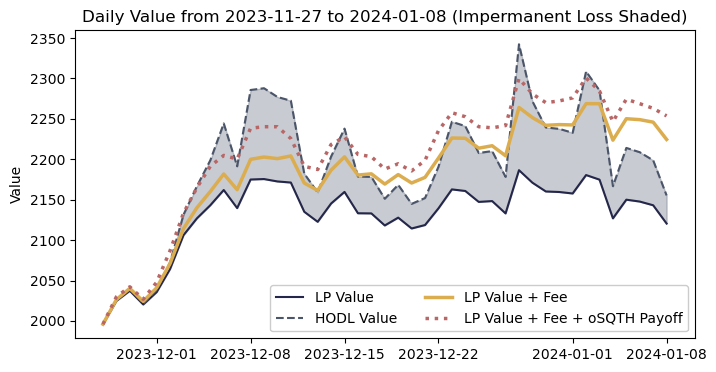

In [18]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=df_final.date, y=df_final.amountV, label='LP Value', color='#242749')
sns.lineplot(x=df_final.date, y=df_final.HODL, label='HODL Value', color='#4B5569', linestyle='--')
sns.lineplot(x=df_final.date, y=df_final.amountV + df_final.feecumsum, label='LP Value + Fee', color='#DBAD4F', linewidth=2.5)
sns.lineplot(x=df_final.date, y=df_final.amountV + df_final.feecumsum + df_final.pp_cumsum_payoff, linestyle=':',
             label='LP Value + Fee + oSQTH Payoff', color='#B96666', linewidth=2.5)

ax.fill_between(df_final.date, list(df_final.amountV), list(df_final.HODL), color='#4B5569', alpha=0.3)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Daily Value from {} to {} (Impermanent Loss Shaded)'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d')))
plt.ylabel('Value')
plt.xlabel(None)
legend = plt.legend(ncol=2, loc='lower right')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
if SAVE:
    plt.savefig('./img/back-testing_gamma.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

## Collecting Options for Delta Hedging Strategy

In [19]:
upper = 5
sample = 100

w_pp = n_oSQTH * oSQTH_price.priceClose.iloc[0] / initial_price
w_pf = 1.5

print("Long a squared power perpetual with a weight of {}".format(w_pp))
# print("Short a perpetual future with a weight of {}".format(w_pf))

Long a squared power perpetual with a weight of 0.7127357548251907


In [20]:
if LIVE:
    currency = 'ETH'
    options = retrieve_deribit_options(currency=currency)
    print('Total of {} instruments for {} available on Deribit'.format(len(options), currency))
    df_options = pd.DataFrame(options)
    df_options[['currency', 'expire_date', 'strike_price', 'option_type']] = (
        df_options.instrument_name.str.split('-', expand=True))
    df_options = df_options.drop_duplicates()
    df_options.to_csv('./data/deribit_options.csv')
else:
    df_options = pd.read_csv('./data/deribit_options.csv', index_col=[0])
df_options.head()

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,ask_price,bid_price,instrument_name,last,low,high,currency,expire_date,strike_price,option_type
0,0.00070,2222.19,2.41,ETH,1704712781414,ETH,0.0,1.0,ETH-26JAN24,2241.650000,...,0.0010,0.0004,ETH-26JAN24-1200-P,0.0011,0.0011,0.0011,ETH,26JAN24,1200,P
1,NaN,2222.19,0.00,ETH,1704712781414,ETH,0.0,0.0,ETH-12JAN24,2226.350000,...,NaN,NaN,ETH-12JAN24-2550-P,0.0755,NaN,NaN,ETH,12JAN24,2550,P
2,0.03050,2222.19,1709.73,ETH,1704712781414,ETH,0.0,24.0,ETH-23FEB24,2269.040000,...,0.0310,0.0300,ETH-23FEB24-2800-C,0.0320,0.0320,0.0320,ETH,23FEB24,2800,C
3,NaN,2222.19,0.00,ETH,1704712781415,ETH,0.0,0.0,SYN.ETH-10JAN24,2224.200483,...,NaN,NaN,ETH-10JAN24-1950-C,NaN,NaN,NaN,ETH,10JAN24,1950,C
4,0.19475,2222.19,175271.62,ETH,1704712781415,ETH,0.0,391.0,ETH-29MAR24,2293.970000,...,0.1995,0.1900,ETH-29MAR24-2000-C,0.1995,0.1995,0.2005,ETH,29MAR24,2000,C


In [21]:
print('Pricing options ...')
df_options['start'] = pd.to_datetime(dpd.date.max())
df_options['expire'] = pd.to_datetime(df_options['expire_date'])
df_options['T'] = (df_options['expire'] - df_options['start']) / np.timedelta64(1, 'Y')
df_options = black_scholes(df_options, initial_price, r=0.05, sigma=0.72)

Pricing options ...


In [22]:
p0 = initial_price
x = np.linspace(0, upper, sample)
x_list = []

for i in df_options.index:
    c = float(df_options.iloc[i]['pricing'] * p0)
    k = float(df_options.iloc[i]['strike_price'])
    if df_options.iloc[i]['option_type'] == 'C':
        yl = (np.maximum(0, x * p0 - k) - c) / p0
        # ys = (c - np.maximum(0, x * p0 - k)) / p0
    else:
        yl = (np.maximum(0, k - x * p0) - c) / p0
        # ys = (c - np.maximum(0, k - x * p0)) / p0
    x_list.append(yl)
    # x_list.append(ys)

In [23]:
mat_X = np.array(x_list)
index_option = list(np.where(~np.isnan(mat_X).any(axis=1))[0])
mat_X = mat_X[~np.isnan(mat_X).any(axis=1)]  # remove options with nan payoff

print('Total of {} valid and unique option candidates'.format(mat_X.shape[0]))

Total of 684 valid and unique option candidates


In [24]:
pu = maxi / initial_price
pl = mini / initial_price

x = np.linspace(0, upper, sample)

y = []  # impermanent loss with concentrated liquidity
for i in x:
    if i < pl:
        y.append((np.sqrt(pl) + i / np.sqrt(pl) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    elif i > pu:
        y.append((i / np.sqrt(pu) + np.sqrt(pu) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    else:
        y.append((2 * np.sqrt(i) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
        
pp = x ** 2 - 1  # payoff from power perpetual
pf = x - 1  # payoff from perpetual future

h_gamma = w_pp * pp  # gamma-neutral hedge
# h_gamma = w_pp * pp - w_pf * pf  # gamma-neutral hedge

y = h_gamma + y

In [25]:
X = torch.from_numpy(mat_X.transpose())
Y = torch.from_numpy(-np.array(y))
X = X.float()
Y = Y.float()

# Instantiate the model
input_size = X.shape[1]
model = LinearRegressionModel(input_size)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [26]:
progress = tqdm(range(1000))

for epoch in progress:
    epoch_loss = 0
    optimizer.zero_grad()
    for i in range(int(sample / upper * 1.5)):
        for p in model.parameters():
            p.data.clamp_(0)
        predictions = model(X[i])

        mse_loss = criterion(predictions, Y[i].unsqueeze(0))
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) * 0.001
        loss = mse_loss + l2_reg
        
        epoch_loss += loss.item()
        # # Backward pass and optimization
        # optimizer.zero_grad()
        loss.backward()

    optimizer.step()
    
    for p in model.parameters():
        p.data.clamp_(0)
    
    progress.set_postfix_str(round(epoch_loss, 4))

100%|██████████| 1000/1000 [00:12<00:00, 82.02it/s, 0.0639]


In [27]:
for p in model.parameters():
    p.data.clamp_(0)
    
w = model.linear.weight.data.numpy()  # weights assigned to each option

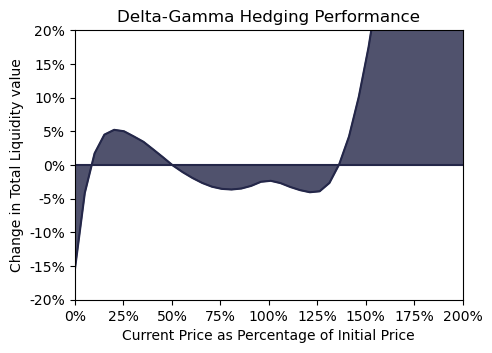

In [28]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

x = np.linspace(0, upper, sample)
h = np.matmul(mat_X.transpose(), np.array(w).transpose())

plt.plot(x, h.transpose().tolist()[0] + np.array(y), color='#242749')
plt.axhline(color='#242749')

ax.set_ylim(-0.2, 0.2)
plt.xlim(0, 2)

ax.fill_between(x, 0, h.transpose().tolist()[0] + np.array(y), color='#242749', alpha=0.8)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Delta-Gamma Hedging Performance')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
if SAVE:
    plt.savefig('./img/back-testing_delta-gamma_static_strangle.png', 
                dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [29]:
df_sel = df_options.loc[index_option].reset_index(drop=True)
df_sel['weight'] = pd.Series(w.flatten())
# df_sel['today'] = pd.to_datetime('today')
df_sel['today'] = pd.to_datetime(dpd.date.max())  # critical correction
df_sel['v_today'] = pd.to_datetime(datetime.utcfromtimestamp(dpd.periodStartUnix.iloc[-1]).strftime('%Y-%m-%d'))
df_sel['expire_date'] = pd.to_datetime(df_sel['expire_date'])
df_sel['v_expire_date'] = df_sel['v_today'] + (df_sel['expire_date'] - df_sel['today'])

df_sel['v_payoff_date'] = pd.to_datetime(df_sel['v_expire_date'] + pd.DateOffset(1)).dt.date
df_sel.v_payoff_date = pd.to_datetime(df_sel.v_payoff_date)
df_sel = df_sel.merge(df_final[['date', 'close']], left_on='v_payoff_date', right_on='date', how='left')
df_sel = df_sel[~df_sel.date.isna()]
df_sel.head()

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,pricing,d1,d2,weight,today,v_today,v_expire_date,v_payoff_date,date,close
0,0.0007,2222.19,2.41,ETH,1704712781414,ETH,0.0,1.0,ETH-26JAN24,2241.650000,...,1.949002e-05,3.318333,3.160544,0.000000e+00,2024-01-08 11:00:00,2023-11-27,2023-12-14 13:00:00,2023-12-15,2023-12-15,2301.378284
1,NaN,2222.19,0.00,ETH,1704712781414,ETH,0.0,0.0,ETH-12JAN24,2226.350000,...,2.770393e-01,-3.413636,-3.484536,7.772876e-03,2024-01-08 11:00:00,2023-11-27,2023-11-30 13:00:00,2023-12-01,2023-12-01,2049.291627
3,NaN,2222.19,0.00,ETH,1704712781415,ETH,0.0,0.0,SYN.ETH-10JAN24,2224.200483,...,3.230203e-02,0.524704,0.477927,0.000000e+00,2024-01-08 11:00:00,2023-11-27,2023-11-28 13:00:00,2023-11-29,2023-11-29,2051.657354
5,0.0004,2222.19,136.63,ETH,1704712781415,ETH,0.0,79.0,SYN.ETH-9JAN24,2223.125725,...,2.916115e-16,-7.377592,-7.405319,0.000000e+00,2024-01-08 11:00:00,2023-11-27,2023-11-27 13:00:00,2023-11-28,2023-11-28,2033.964624
8,0.0004,2222.19,0.00,ETH,1704712781415,ETH,0.0,0.0,ETH-12JAN24,2226.350000,...,3.613119e-16,-7.471216,-7.542116,1.025724e-17,2024-01-08 11:00:00,2023-11-27,2023-11-30 13:00:00,2023-12-01,2023-12-01,2049.291627


In [30]:
df_sel.loc[
    (df_sel.option_type == 'P') & 
    (df_sel.v_expire_date < df_final.date.max()) & 
    (df_sel.strike_price < initial_price)
].sort_values('weight', ascending=False).iloc[0]

mid_price                                0.0004
estimated_delivery_price                2222.19
volume_usd                                  0.0
quote_currency                              ETH
creation_timestamp                1704712781423
base_currency                               ETH
interest_rate                               0.0
volume                                      0.0
underlying_index                    ETH-26JAN24
underlying_price                        2241.65
price_change                                NaN
mark_price                             0.000438
open_interest                             806.0
ask_price                                0.0006
bid_price                                0.0002
instrument_name              ETH-26JAN24-1000-P
last                                     0.0006
low                                         NaN
high                                        NaN
currency                                    ETH
expire_date                 2024-01-26 0

In [31]:
df_sel.loc[
    (df_sel.option_type == 'C') & 
    (df_sel.v_expire_date < df_final.date.max()) & 
    (df_sel.strike_price > initial_price)
].sort_values('weight', ascending=False).iloc[0]

mid_price                                   NaN
estimated_delivery_price                2222.19
volume_usd                                 0.22
quote_currency                              ETH
creation_timestamp                1704712781419
base_currency                               ETH
interest_rate                               0.0
volume                                      1.0
underlying_index                SYN.ETH-10JAN24
underlying_price                    2224.200483
price_change                                0.0
mark_price                             0.000166
open_interest                               1.0
ask_price                                0.0004
bid_price                                   NaN
instrument_name              ETH-10JAN24-2900-C
last                                     0.0001
low                                      0.0001
high                                     0.0001
currency                                    ETH
expire_date                 2024-01-10 0

In [32]:
df_strangle = pd.concat([
    df_sel.loc[
        (df_sel.option_type == 'P') & 
        (df_sel.v_expire_date < df_final.date.max())
    ].sort_values('weight', ascending=False).iloc[0],
    df_sel.loc[
        (df_sel.option_type == 'C') & 
        (df_sel.v_expire_date < df_final.date.max())
    ].sort_values('weight', ascending=False).iloc[0]
], axis=1).transpose()
df_strangle

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,pricing,d1,d2,weight,today,v_today,v_expire_date,v_payoff_date,date,close
621,NaN,2222.19,0.0,ETH,1704712781428,ETH,0.0,0.0,ETH-26JAN24,2241.64,...,1.19929,-4.915963,-5.073752,0.037523,2024-01-08 11:00:00,2023-11-27,2023-12-14 13:00:00,2023-12-15,2023-12-15,2301.378284
140,NaN,2222.19,0.22,ETH,1704712781419,ETH,0.0,1.0,SYN.ETH-10JAN24,2224.200483,...,0.0,-7.959744,-8.006522,0.035461,2024-01-08 11:00:00,2023-11-27,2023-11-28 13:00:00,2023-11-29,2023-11-29,2051.657354


In [33]:
p0 = initial_price
x = np.linspace(0, upper, sample)
x_list = []

for i in range(2):
    c = float(df_strangle.iloc[i]['pricing'] * p0)
    k = float(df_strangle.iloc[i]['strike_price'])
    if df_strangle.iloc[i]['option_type'] == 'C':
        yl = (np.maximum(0, x * p0 - k) - c) / p0
        # ys = (c - np.maximum(0, x * p0 - k)) / p0
    else:
        yl = (np.maximum(0, k - x * p0) - c) / p0
        # ys = (c - np.maximum(0, k - x * p0)) / p0
    x_list.append(yl)
    # x_list.append(ys)

mat_X = np.array(x_list)
index_option = list(np.where(~np.isnan(mat_X).any(axis=1))[0])
mat_X = mat_X[~np.isnan(mat_X).any(axis=1)]  # remove options with nan payoff

print('Total of {} valid and unique option candidates'.format(mat_X.shape[0]))

Total of 2 valid and unique option candidates


In [34]:
X = torch.from_numpy(mat_X.transpose())
Y = torch.from_numpy(-np.array(y))
X = X.float()
Y = Y.float()

# Instantiate the model
input_size = X.shape[1]
model = LinearRegressionModel(input_size)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

progress = tqdm(range(1000))

for epoch in progress:
    epoch_loss = 0
    optimizer.zero_grad()
    for i in range(int(sample / upper * 1)):
        for p in model.parameters():
            p.data.clamp_(0)
        predictions = model(X[i])

        mse_loss = criterion(predictions, Y[i].unsqueeze(0))
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) * 0.01
        loss = mse_loss + l2_reg
        
        epoch_loss += loss.item()
        # # Backward pass and optimization
        # optimizer.zero_grad()
        loss.backward()

    optimizer.step()
    
    for p in model.parameters():
        p.data.clamp_(0)
    
    progress.set_postfix_str(round(epoch_loss, 4))

100%|██████████| 1000/1000 [00:08<00:00, 118.00it/s, 0.9885]


In [35]:
for p in model.parameters():
    p.data.clamp_(0)

w = model.linear.weight.data.numpy()  # weights assigned to each option
w

array([[8.8799793e-01, 7.2169033e-20]], dtype=float32)

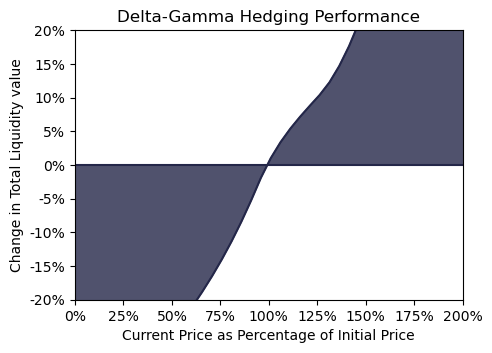

In [36]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

x = np.linspace(0, upper, sample)
h = np.matmul(mat_X.transpose(), np.array(w).transpose())

plt.plot(x, h.transpose().tolist()[0] + np.array(y), color='#242749')
plt.axhline(color='#242749')

ax.set_ylim(-0.2, 0.2)
plt.xlim(0, 2)

ax.fill_between(x, 0, h.transpose().tolist()[0] + np.array(y), color='#242749', alpha=0.8)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Delta-Gamma Hedging Performance')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
if SAVE:
    plt.savefig('./img/back-testing_delta-gamma_static_strangle.png', 
                dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [37]:
df_sel = df_strangle.copy()
df_sel['weight'] = df_sel['weight'].astype('float')
df_sel['weight'] = w.flatten().tolist()
if AROUND: df_sel.weight = np.around((df_sel.weight / df_sel.pricing).astype('float')) * df_sel.pricing
df_sel['weight'] /= 100 
df_sel

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,pricing,d1,d2,weight,today,v_today,v_expire_date,v_payoff_date,date,close
621,NaN,2222.19,0.0,ETH,1704712781428,ETH,0.0,0.0,ETH-26JAN24,2241.64,...,1.19929,-4.915963,-5.073752,0.011993,2024-01-08 11:00:00,2023-11-27,2023-12-14 13:00:00,2023-12-15,2023-12-15,2301.378284
140,NaN,2222.19,0.22,ETH,1704712781419,ETH,0.0,1.0,SYN.ETH-10JAN24,2224.200483,...,0.0,-7.959744,-8.006522,0.0,2024-01-08 11:00:00,2023-11-27,2023-11-28 13:00:00,2023-11-29,2023-11-29,2051.657354


In [38]:
df_sel['payoff'] = 0
df_sel.loc[df_sel.option_type == 'C', 'payoff'] = df_sel.weight * (
        np.maximum(0, df_sel.close - df_sel.strike_price) - df_sel.pricing * initial_price)
df_sel.loc[df_sel.option_type == 'P', 'payoff'] = df_sel.weight * (
        np.maximum(0, df_sel.strike_price - df_sel.close) - df_sel.pricing * initial_price)
df_sel['payoff'].sum()

-3.5376384041678444

In [39]:
df_hedge = df_sel.groupby('date')['payoff'].sum().reset_index()
df_hedge.date = pd.to_datetime(df_hedge.date)
df_hedge.head()

,date,payoff
0,2023-11-29,-0.0
1,2023-12-15,-3.537638


In [40]:
df_final.date = pd.to_datetime(df_final.date)
df_final = df_final.merge(df_hedge, on='date', how='left')
df_final = df_final.fillna(0)
df_final['delta_cumsum_payoff'] = df_final['payoff'].cumsum()
if SAVE:
    df_final.to_csv('./results/back-testing_delta-gamma_strangle.csv')
df_final.head()

,date,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm,timeClose,pp_cumsum_payoff,payoff,delta_cumsum_payoff
0,2023-11-27,1995.847202,414.618074,0.792260,1995.847202,0.138075,2020.023789,1995.847202,24.176588,100.0,0.138075,24.314663,100.000000,1.211345,1.218263,0.006918,2023-11-27,0.000000,0.0,0.0
1,2023-11-28,2024.748294,551.171005,0.724485,2033.964624,1.543008,2035.320632,2026.046096,9.274536,100.0,1.681082,10.955618,101.513086,0.464692,0.548921,0.084229,2023-11-28,3.363636,0.0,0.0
2,2023-11-29,2037.293227,614.118984,0.693671,2051.657354,1.274906,2020.728024,2040.063331,-19.335307,100.0,2.955989,-16.379318,102.215407,-0.968777,-0.820670,0.148107,2023-11-29,1.964186,-0.0,0.0
3,2023-11-30,2020.336875,529.601959,0.735105,2027.919857,0.941741,2037.722755,2021.257071,16.465684,100.0,3.897730,20.363413,101.273137,0.824997,1.020289,0.195292,2023-11-30,2.640804,0.0,0.0
4,2023-12-01,2035.647347,605.717859,0.697768,2049.291627,1.416932,2060.757246,2038.189061,22.568184,100.0,5.314661,27.882846,102.121498,1.130757,1.397043,0.266286,2023-12-01,6.871640,0.0,0.0


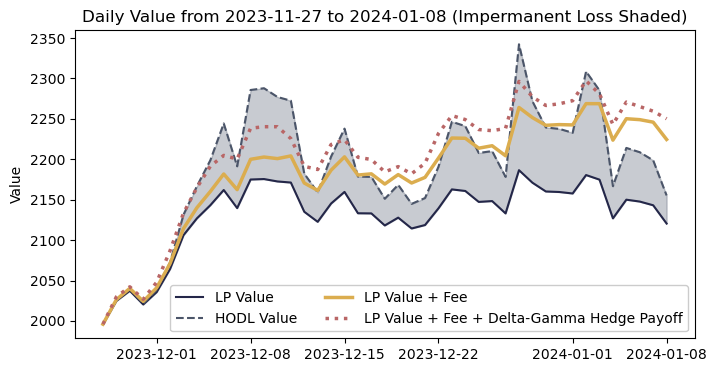

In [41]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=df_final.date, y=df_final.amountV, label='LP Value', color='#242749')
sns.lineplot(x=df_final.date, y=df_final.HODL, label='HODL Value', color='#4B5569', linestyle='--')
sns.lineplot(x=df_final.date, y=df_final.amountV + 
                                df_final.feecumsum, label='LP Value + Fee', color='#DBAD4F', linewidth=2.5)
sns.lineplot(x=df_final.date, y=df_final.amountV + 
                                df_final.feecumsum + 
                                df_final.pp_cumsum_payoff + 
                                df_final.delta_cumsum_payoff, linestyle=':',
             label='LP Value + Fee + Delta-Gamma Hedge Payoff', color='#B96666', linewidth=2.5)

ax.fill_between(df_final.date, list(df_final.amountV), list(df_final.HODL), color='#4B5569', alpha=0.3)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Daily Value from {} to {} (Impermanent Loss Shaded)'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d')))
plt.ylabel('Value')
plt.xlabel(None)
legend = plt.legend(ncol=2)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
if SAVE:
    plt.savefig('./img/back-testing_delta-gamma_strangle.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()